In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

In [4]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [5]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [6]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter duplicates and rare(bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [6]:
# #read cat in each chip: 
# cats = []
# for i in range(100):
#     print i 
#     if i < 10: 
#         suffix = '0{}'.format(i)
#     else: 
#         suffix = '{}'.format(i)
#     filename  = 'final{}.fits'.format(suffix)
#     results = fits.open('/Users/Ismael/aegis/WeakLensingDeblending/project1/{}'.format(filename))
#     hdr = results[0].header
#     cats.append(astropy.table.Table.read(results,hdu=1))

In [22]:
import pickle

pickle.dump( cats, open( "/Users/Ismael/Downloads/cats-each-chip.p", "wb" ) )

In [1]:
import pickle
cats = pickle.load( open( "/Users/Ismael/code/lensing/WeakLensingDeblending/cats-each-chip.p", "rb" ) )

In [8]:
a = 0 
for cat in cats: 
    a+=len(cat)
print a 

869685


In [10]:
lists_high_pur_high_snr = [[],[],[],[]]
lists_high_pur_low_snr = [[],[],[],[]]
lists_low_pur_high_snr = [[],[],[],[]]
lists_low_pur_low_snr = [[],[],[],[]]
full_percentages = [[],[],[],[]]
count_lengths_cats = []
count_lengths_analyzecats = []



for cat in cats: 

    analyze_cats=[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]
    count_lengths_cats.append(len(cat))

    for i,(analyze_cat) in enumerate(analyze_cats):

        high_pur_high_snr = up_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
        high_pur_low_snr = down_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
        low_pur_high_snr = up_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
        low_pur_low_snr = down_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    
        #calculate percentages 
        lists_high_pur_high_snr[i].append(float(len(high_pur_high_snr))/len(analyze_cat))
        lists_high_pur_low_snr[i].append(float(len(high_pur_low_snr))/len(analyze_cat))
        lists_low_pur_high_snr[i].append(float(len(low_pur_high_snr))/len(analyze_cat))
        lists_low_pur_low_snr[i].append(float(len(low_pur_low_snr))/len(analyze_cat))
        full_percentages[i].append(float(len(analyze_cat))/len(cat))


        

In [15]:
count_lengths_cats = []
count_lengths_analyzecats = []




for cat in cats: 
    count_lengths_cats.append(len(cat))
    analyze_cats=[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]
    count_lengths_analyzecats.append(sum([len(cat) for cat in analyze_cats]))

print sum(count_lengths_cats)
print sum(count_lengths_analyzecats)

869685
869685


In [11]:
print lists_high_pur_high_snr[0][0]
print lists_high_pur_low_snr[0][0]
print lists_low_pur_high_snr[0][0]
print lists_low_pur_low_snr[0][0]

0.685089974293
0.0122107969152
0.252570694087
0.0501285347044


mean for high_pur_high_snr + detc_and_notambig: 0.668825537628
mean for high_pur_high_snr + detc_and_ambig: 0.145997027973
mean for high_pur_high_snr + notdetc_and_notambig: 0.0383332189824
mean for high_pur_high_snr + notdetc_and_ambig: 0.000763031587995
mean for high_pur_low_snr + detc_and_notambig: 0.0118559696139
mean for high_pur_low_snr + detc_and_ambig: 0.00131085617372
mean for high_pur_low_snr + notdetc_and_notambig: 0.335924159116
mean for high_pur_low_snr + notdetc_and_ambig: 0.000557319769242
mean for low_pur_high_snr + detc_and_notambig:0.27021538714
mean for low_pur_high_snr + detc_and_ambig:0.350532667358
mean for low_pur_high_snr + notdetc_and_notambig:0.032499160232
mean for low_pur_high_snr + notdetc_and_ambig:0.0638388241095
mean for low_pur_low_snr + detc_and_notambig:0.0491031056184
mean for low_pur_low_snr + detc_and_ambig:0.502159448495
mean for low_pur_low_snr + notdetc_and_notambig:0.59324346167
mean for low_pur_low_snr + notdetc_and_ambig:0.934840824533
mean p

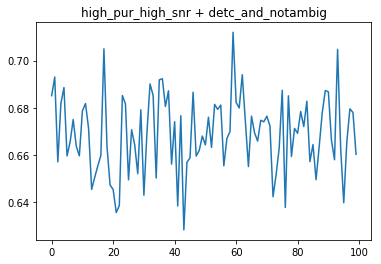

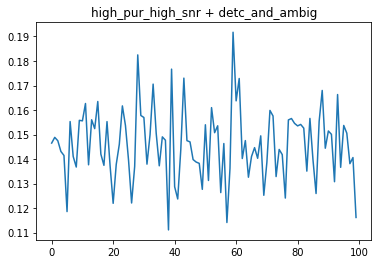

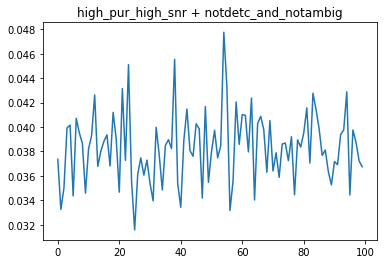

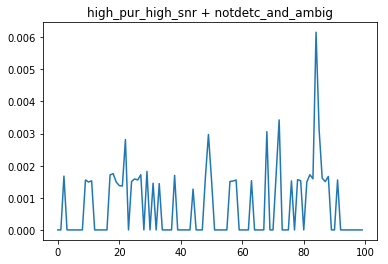

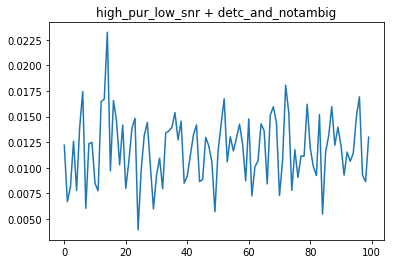

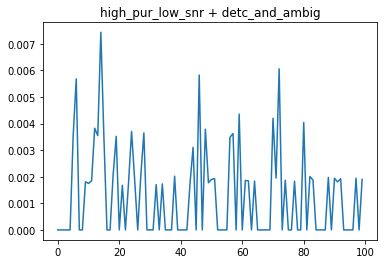

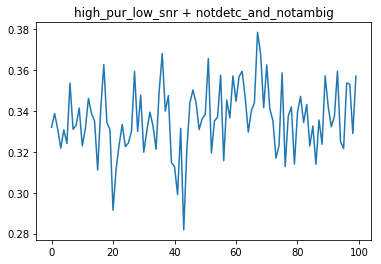

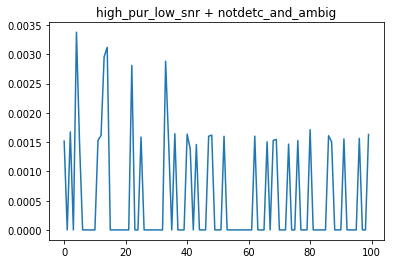

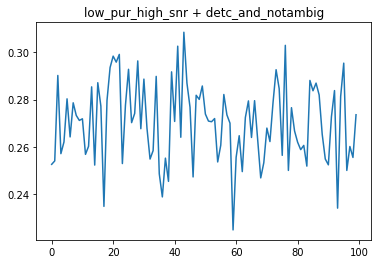

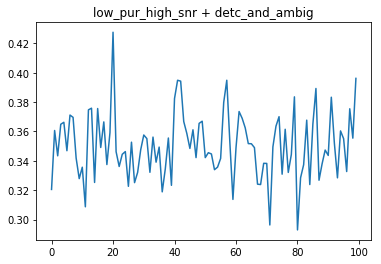

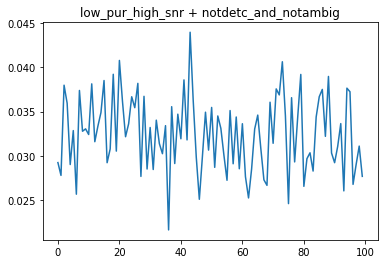

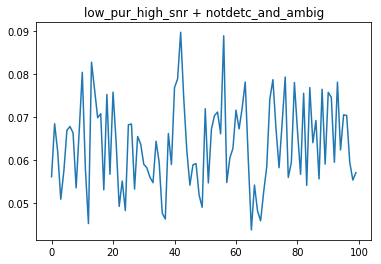

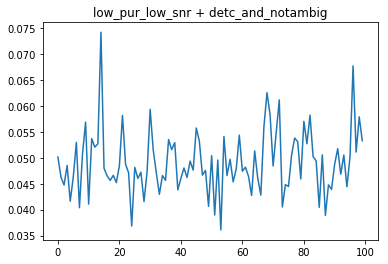

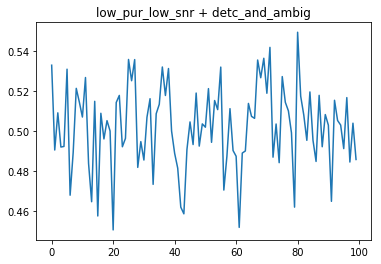

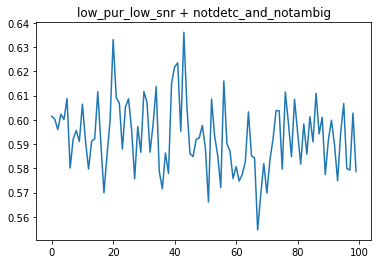

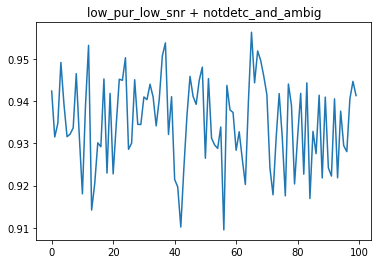

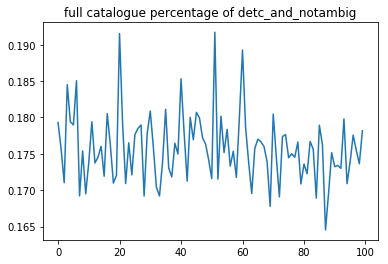

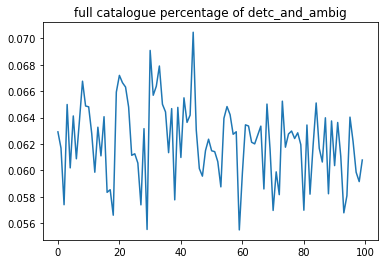

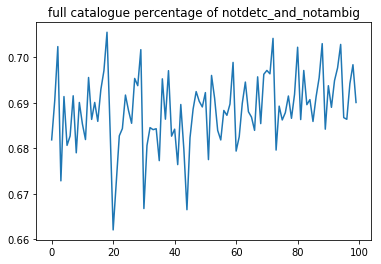

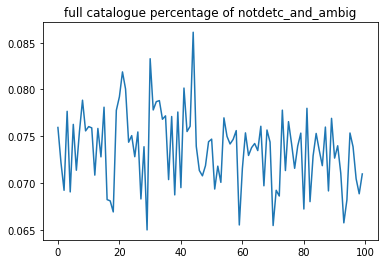

In [12]:
for name,l in zip(['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig'],lists_high_pur_high_snr): 
    plt.figure()
    plt.title('high_pur_high_snr + {}'.format(name))
    plt.plot(range(100),l)
    print 'mean for high_pur_high_snr + {}: {}'.format(name,np.mean(l))
    
for name,l in zip(['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig'],lists_high_pur_low_snr): 
    plt.figure()
    plt.title('high_pur_low_snr + {}'.format(name))
    plt.plot(range(100),l)
    print 'mean for high_pur_low_snr + {}: {}'.format(name,np.mean(l))
    
for name,l in zip(['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig'],lists_low_pur_high_snr): 
    plt.figure()
    plt.title('low_pur_high_snr + {}'.format(name))
    plt.plot(range(100),l)
    print 'mean for low_pur_high_snr + {}:{}'.format(name,np.mean(l))
    
for name,l in zip(['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig'],lists_low_pur_low_snr): 
    plt.figure()
    plt.title('low_pur_low_snr + {}'.format(name))
    plt.plot(range(100),l)
    print 'mean for low_pur_low_snr + {}:{}'.format(name,np.mean(l))

for name,l in zip(['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig'],full_percentages): 
    plt.figure()
    plt.title('full catalogue percentage of {}'.format(name))
    plt.plot(range(100),l)
    print 'mean percentages for full catalogue of {}:{}'.format(name,np.mean(l))

(array([ 688.,  920.,  933.,  842.,  614.,  496.,  413.,  304.,  283.,
         238.,  211.,  211.,  154.,  126.,  100.,  112.,   98.,   85.,
          88.,   57.,   65.,   75.,   55.,   51.,   50.,   43.,   46.,
          39.,   40.,   38.,   29.,   32.,   36.,   31.,   22.,   23.,
          24.,   20.,   23.,   19.,   24.,   19.,   16.,   17.,   22.,
          18.,   20.,   16.,    9.,   16.]),
 array([  0. ,   0.4,   0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,
          3.6,   4. ,   4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,
          7.2,   7.6,   8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,
         10.8,  11.2,  11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,
         14.4,  14.8,  15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,
         18. ,  18.4,  18.8,  19.2,  19.6,  20. ]),
 <a list of 50 Patch objects>)

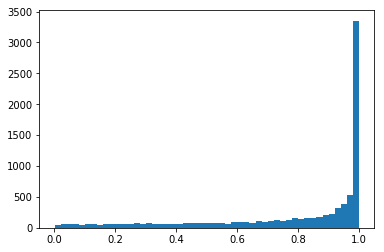

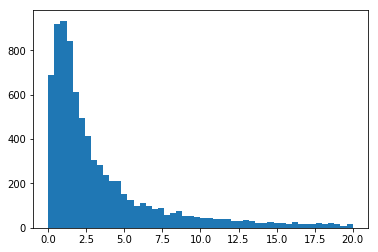

In [12]:
#histogram of one of the chips 
plt.figure()
plt.hist(cats[0]['purity'],bins=50)
plt.figure()
plt.hist(cats[0]['snr_grpf'],bins=50,range=(0,20))

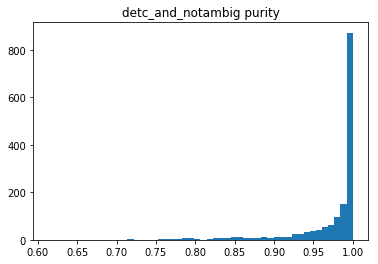

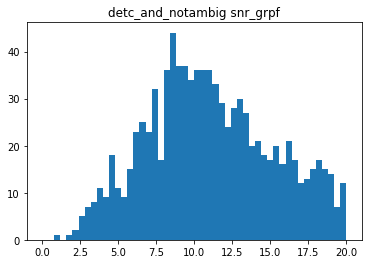

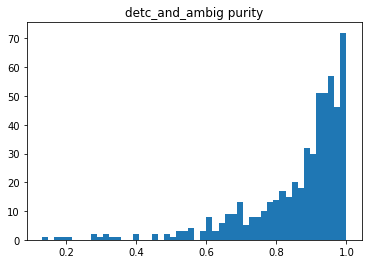

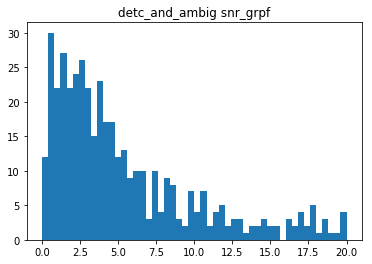

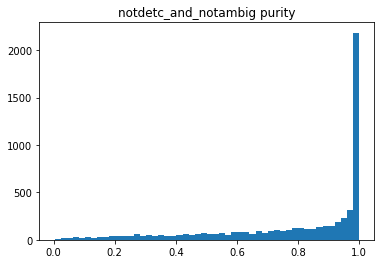

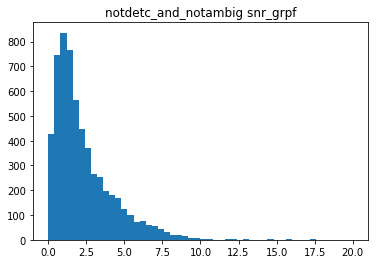

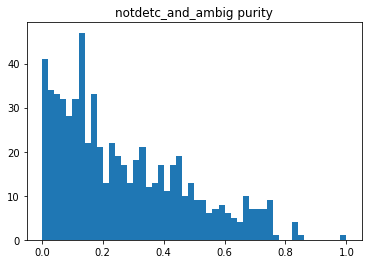

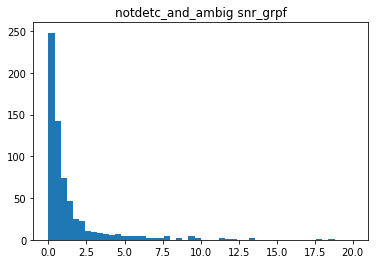

In [21]:
#what about in each region: 
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
analyze_cats=[detc_and_notambig(cats[0]),detc_and_ambig(cats[0]),notdetc_and_notambig(cats[0]),notdetc_and_ambig(cats[0])]
for cat,name in zip(analyze_cats,names): 
    #histogram of one of the chips 
    plt.figure()
    plt.title(name + ' purity')
    plt.hist(cat['purity'],bins=50)
    plt.figure()
    plt.title(name + ' snr_grpf')
    plt.hist(cat['snr_grpf'],bins=50,range=(0,20))


## Histogram of erros of one chip vs one square degree 

In [7]:
import os 
os.chdir('/Users/Ismael/code/lensing/WeakLensingDeblending/')
import descwl

In [29]:
#this is for the section
cat = descwl.output.Reader('/Users/Ismael/aegis/WeakLensingDeblending/project1/final99.fits').results
detected,matched,indices,distance = cat.match_sextractor('/Users/Ismael/aegis/WeakLensingDeblending/project1/out99-2x.cat')




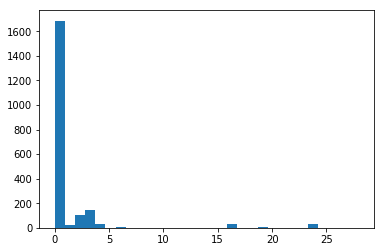

In [30]:
plt.hist(detected['FLAGS'],bins=30)
plt.show()

In [22]:
#this is for the one square degree 
cat = descwl.output.Reader('/Users/Ismael/aegis/WeakLensingDeblending/project1/final_fits.fits').results



In [23]:
detected,matched,indices,distance = cat.match_sextractor('/Users/Ismael/aegis/WeakLensingDeblending/project1/outcat-x.cat')



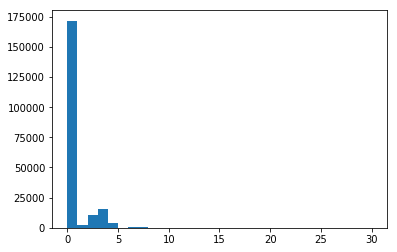

In [27]:
plt.hist(detected['FLAGS'],bins=30)
plt.show()

In [25]:
print len(cat.table)
print len(detected)

869685
206272
